# 构建一个简单的图分类模型示例

### 目标：训练一个图模型，是的该图模型可以分区分图上的不同颜色的节点

In [1]:
import torch
import torch_geometric
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)


# 验证 CUDA 是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"PyG version: {torch_geometric.__version__}")
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.3.1
PyG version: 2.6.1
Using device: cuda
CUDA available: True
CUDA version: 12.1


In [4]:
from torch_geometric.data import Data

def build_graph():
    """
    构建图 (PyTorch Geometric 实现)
    Returns:
        Data: PyG的图数据对象
    """
    # 使用数字定义图中的节点数目
    num_nodes = 10
    
    # 定义图中的边集合
    edge_list = [
        (2, 0), (2, 1), (3, 1), (4, 0), (5, 0), (6, 0), (6, 4), (6, 5),
        (7, 0), (7, 1), (7, 2), (7, 3), (8, 0), (9, 7)
    ]
    
    # 将边列表转换为PyG需要的格式 (2, num_edges)的张量
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    
    # 随机初始化节点特征，特征维度为d
    d = 16
    node_feat = torch.randn(num_nodes, d, dtype=torch.float)
    
    # 随机为每条边赋值一个权重
    edge_attr = torch.randn(len(edge_list), 1, dtype=torch.float)
    
    # 构建PyG的图对象
    g = Data(
        x=node_feat,                    # 节点特征
        edge_index=edge_index,  # 边的连接关系
        edge_attr=edge_attr,    # 边的特征
        num_nodes=num_nodes     # 节点数量
    )
    
    # 将图移动到GPU（如果可用）
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    g = g.to(device)
    
    return g
    

g = build_graph()
print(f"图的节点数目：{g.num_nodes}")
print(f"图的边数目：{g.num_edges}")
print(f"图的节点特征：{g.x, g.x.shape}")
print(f"图的边特征：{g.edge_attr, g.edge_attr.shape}")


图的节点数目：10
图的边数目：14
图的节点特征：(tensor([[ 1.9709,  0.5996, -0.0056,  1.7125,  2.4079, -1.4576, -0.5045, -1.2231,
         -0.9262,  0.5025,  1.4496, -0.1270,  0.2145,  0.2017, -0.8368,  1.0841],
        [ 1.5417, -0.9592,  0.5980, -2.1337,  0.7226, -1.0389,  0.2069, -0.9928,
          0.4554,  0.3610,  0.0239, -1.2629, -1.3171, -2.1162,  0.4377, -0.9505],
        [-0.9417,  0.3296, -0.5686, -0.3812, -0.7491,  0.6649, -1.6220,  0.3199,
         -1.3149,  1.4097,  0.8486, -0.4570, -0.0404,  0.7389,  0.6213,  1.3562],
        [ 2.3118,  1.1264,  0.7300,  1.8441, -0.4589,  1.2628,  0.4647, -0.6405,
         -1.8633, -0.5980,  0.2388, -1.5161, -1.7175, -0.6696, -2.7161, -0.6775],
        [-0.6886, -0.5953,  0.0490,  0.4026, -1.4621, -0.7819,  0.5151, -0.0455,
         -0.3980,  1.5911, -0.5948, -0.7667, -1.1550,  0.7561, -1.2339, -0.2500],
        [ 0.3009, -0.2749,  2.0070, -1.9086,  0.5309, -0.3471,  0.6328,  1.3340,
          0.7789,  1.0741, -0.6286, -0.0741,  1.1929,  0.0905,  0.5939, -0.93

In [5]:
def get_neighbors(g, node_idx):
    """
    获取指定节点的前置和后续邻居
    Args:
        g: PyG的图对象
        node_idx: 节点索引
    Returns:
        successors: 后续邻居列表
        predecessors: 前置邻居列表
    """
    edge_index = g.edge_index
    
    # 获取后续邻居（当前节点作为源节点）
    successors = edge_index[1][edge_index[0] == node_idx].tolist()
    
    # 获取前置邻居（当前节点作为目标节点）
    predecessors = edge_index[0][edge_index[1] == node_idx].tolist()
    
    return successors, predecessors


succ, pred = get_neighbors(g, 0)
print(f"0号节点的后续邻居：{succ}")
print(f"0号节点的前置邻居：{pred}")

succ, pred = get_neighbors(g, 5)
print(f"5号节点的后续邻居：{succ}")
print(f"5号节点的前置邻居：{pred}")


0号节点的后续邻居：[]
0号节点的前置邻居：[2, 4, 5, 6, 7, 8]
5号节点的后续邻居：[0]
5号节点的前置邻居：[6]


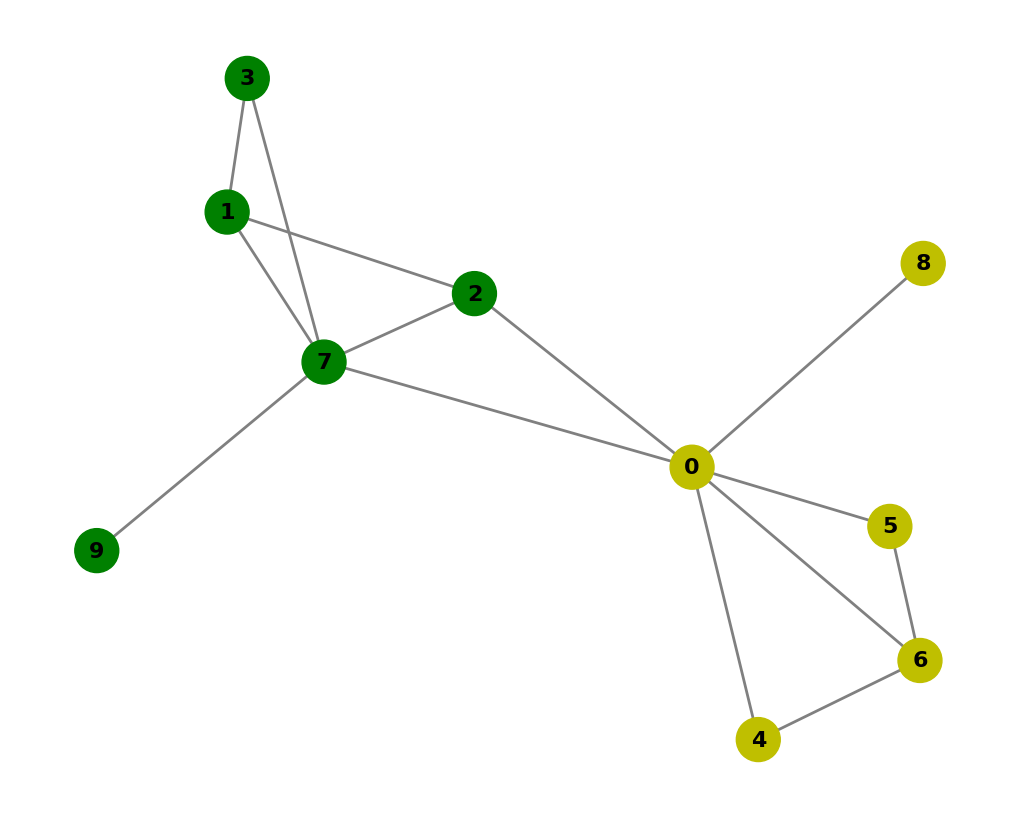

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx # networkx是一个常用的绘制复杂图形的Python包。
from torch_geometric.utils import to_networkx


def display_graph(g, 
                 node_size=1000,
                 node_colors=None,
                 figsize=(10, 8),
                 with_labels=True,
                 save_path='gcn.png'):
    """
    无向图可视化函数
    """
    nx_G = to_networkx(g, to_undirected=True)
    plt.figure(figsize=figsize)
    
    if node_colors is None:
        node_colors = ['y','g','g','g','y','y','y','g','y','g']
    
    pos = nx.spring_layout(nx_G, k=1, iterations=50)
    
    nx.draw(nx_G, 
           pos=pos,
           with_labels=with_labels,
           node_color=node_colors, 
           node_size=node_size,
           font_size=16,
           font_weight='bold',
           width=2,
           edge_color='gray')
    
    if save_path:
        plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()
    
    
# 增强版本的函数，提供更多自定义选项
def display_directed_graph_advanced(g, 
                                 node_size=1000,
                                 node_colors=None,
                                 figsize=(12, 10),
                                 arrow_size=20,
                                 edge_curve=0.2,
                                 save_path='directed_gcn.png'):
    """
    有向图可视化函数
    Args:
        g: PyTorch Geometric 图对象
        node_size: 节点大小
        node_colors: 节点颜色列表
        figsize: 图形大小
        arrow_size: 箭头大小
        edge_curve: 边的弯曲程度 (0 表示直线)
        save_path: 保存路径
    """
    nx_G = to_networkx(g, to_undirected=False)
    plt.figure(figsize=figsize)
    
    if node_colors is None:
        node_colors = ['y','g','g','g','y','y','y','g','y','g']
    
    pos = nx.spring_layout(nx_G, k=2, iterations=50)
    
    # 绘制节点
    nx.draw_networkx_nodes(nx_G, 
                          pos=pos,
                          node_color=node_colors, 
                          node_size=node_size)
    
    # 绘制节点标签
    nx.draw_networkx_labels(nx_G, 
                           pos=pos,
                           font_size=16,
                           font_weight='bold')
    
    # 分别绘制单向边和双向边
    edges = nx_G.edges()
    bidirectional_edges = []
    single_edges = []
    
    # 识别双向边
    for e in edges:
        if (e[1], e[0]) in edges and e[0] < e[1]:  # 只添加一次
            bidirectional_edges.append(e)
        elif (e[1], e[0]) not in edges:
            single_edges.append(e)
    
    # 绘制单向边
    nx.draw_networkx_edges(nx_G, 
                          pos=pos,
                          edgelist=single_edges,
                          arrows=True,
                          arrowsize=arrow_size,
                          width=2,
                          edge_color='gray',
                          arrowstyle='->',
                          connectionstyle=f'arc3, rad=0')
    
    # 绘制双向边（使用不同的弯曲度）
    nx.draw_networkx_edges(nx_G, 
                          pos=pos,
                          edgelist=bidirectional_edges,
                          arrows=True,
                          arrowsize=arrow_size,
                          width=2,
                          edge_color='blue',
                          arrowstyle='->',
                          connectionstyle=f'arc3, rad={edge_curve}')
    
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()
    
    


display_graph(g)


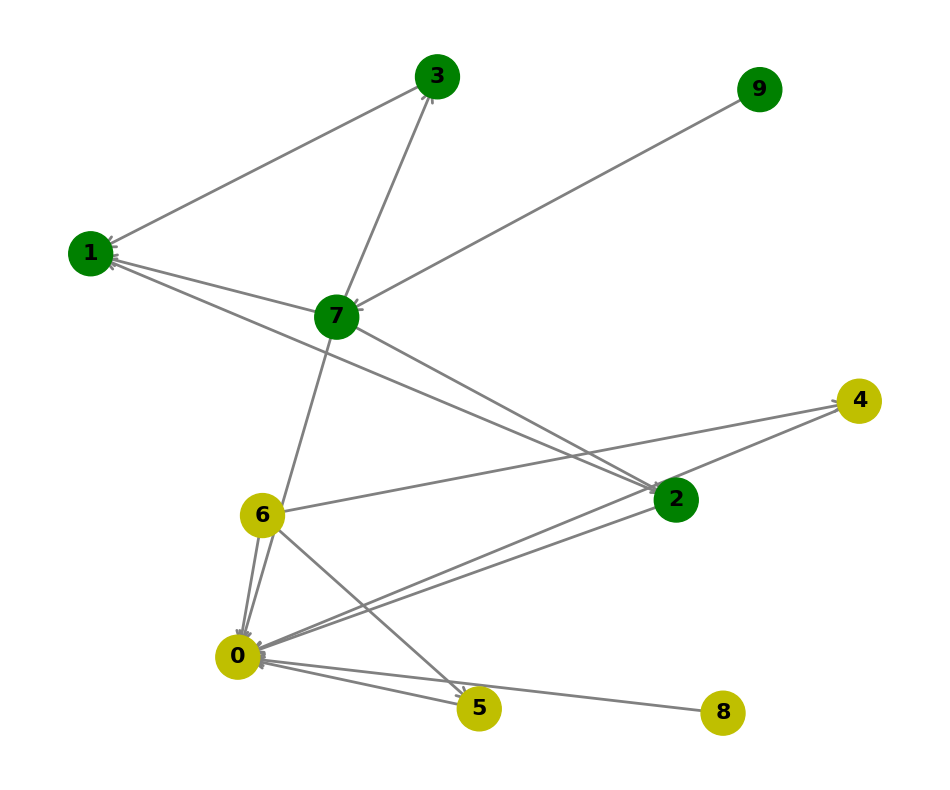

In [10]:
display_directed_graph_advanced(g)

### 定义图模型

定义一个同时传递节点特征和边权重的简单模型层

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

class CustomGraphLayer(MessagePassing):
    """
    定义一个同时传递节点特征和边权重的简单模型层
    """
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: 输入特征维度
            out_channels: 输出特征维度
        """
        super().__init__(aggr='add')  # 使用加法聚合
        self.linear = nn.Linear(in_channels, out_channels, bias=False)
        
    def forward(self, x, edge_index, edge_attr):
        """
        前向传播
        Args:
            x: 节点特征 [num_nodes, in_channels]
            edge_index: 边的连接关系 [2, num_edges]
            edge_attr: 边的特征 [num_edges, 1]
        """
        # 添加自环
        edge_index, edge_attr = add_self_loops(edge_index, edge_attr)
        
        # 开始消息传递
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        
        # 线性变换
        out = self.linear(out)
        
        return out
    
    def message(self, x_j, edge_attr):
        """
        定义消息如何传递
        Args:
            x_j: 源节点的特征
            edge_attr: 边的特征
        """
        # 将源节点的特征与边特征相乘
        return x_j * edge_attr.view(-1, 1)

In [12]:
class GNNModel(nn.Module):
    """
    完整的图神经网络模型
    """
    def __init__(self, in_channels, hidden_channels, out_channels):
        """
        Args:
            in_channels: 输入特征维度
            hidden_channels: 隐藏层维度
            out_channels: 输出维度
        """
        super().__init__()
        self.conv1 = CustomGraphLayer(in_channels, hidden_channels)
        self.conv2 = CustomGraphLayer(hidden_channels, out_channels)
        
    def forward(self, data):
        """
        前向传播
        Args:
            data: PyG的Data对象，包含x, edge_index, edge_attr等属性
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # 第一层
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        
        # 第二层
        x = self.conv2(x, edge_index, edge_attr)
        
        return x

In [13]:
from torch_geometric.data import Data
    
# 创建一个简单的图用于测试
x = torch.randn(10, 16)  # 10个节点，每个节点16维特征
edge_index = torch.tensor([[0, 1, 1, 2],
                            [1, 0, 2, 1]], dtype=torch.long)  # 4条边
edge_attr = torch.randn(4, 1)  # 每条边一个权重

# 创建图数据对象
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# 创建模型
model = GNNModel(in_channels=16, hidden_channels=32, out_channels=8)

# 如果有GPU则使用GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

# 前向传播
output = model(data)

print(f"Input shape: {data.x.shape}")
print(f"Output shape: {output.shape}")
print(f"Device: {output.device}")

Input shape: torch.Size([10, 16])
Output shape: torch.Size([10, 8])
Device: cuda:0


### 训练前准备

定义训练、评估、绘图等方法

In [14]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
import matplotlib.pyplot as plt


def train_model(model, data, labels, epochs=200, lr=0.01):
    """
    训练模型
    Args:
        model: GNN模型
        data: PyG的Data对象
        labels: 节点标签
        epochs: 训练轮数
        lr: 学习率
    """
    # 将标签转换为tensor并移动到相应设备
    labels = torch.tensor(labels, dtype=torch.float).to(data.x.device)
    
    # 定义优化器和损失函数
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    
    # 用于记录训练过程
    losses = []
    accuracies = []
    
    # 训练循环
    model.train()
    for epoch in range(epochs):
        # 清零梯度
        optimizer.zero_grad()
        
        # 前向传播
        output = model(data)
        
        # 计算损失
        loss = criterion(output, labels)
        
        # 反向传播
        loss.backward()
        
        # 更新参数
        optimizer.step()
        
        # 计算准确率
        with torch.no_grad():
            pred = (torch.sigmoid(output) > 0.5).float()
            acc = (pred == labels).float().mean().item()
        
        # 记录损失和准确率
        losses.append(loss.item())
        accuracies.append(acc)
        
        # 每20轮打印一次进度
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {acc:.4f}')
    
    return losses, accuracies


def plot_training_history(losses, accuracies):
    """
    绘制训练历史
    Args:
        losses: 损失列表
        accuracies: 准确率列表
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 绘制损失曲线
    ax1.plot(losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    
    # 绘制准确率曲线
    ax2.plot(accuracies)
    ax2.set_title('Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    
    plt.tight_layout()
    plt.show()


def evaluate_model(model, data, labels):
    """
    评估模型
    Args:
        model: GNN模型
        data: PyG的Data对象
        labels: 节点标签
    """
    model.eval()
    with torch.no_grad():
        output = model(data)
        pred = (torch.sigmoid(output) > 0.5).float()
        acc = (pred == labels).float().mean().item()
        
        # 转换为numpy进行详细评估
        pred_np = pred.cpu().numpy()
        labels_np = labels.cpu().numpy()
        
        print("\nModel Evaluation:")
        print(f"Accuracy: {acc:.4f}")
        print("\nPredictions vs True Labels:")
        for i in range(len(pred_np)):
            print(f"Node {i}: Predicted={int(pred_np[i][0])}, True={int(labels_np[i][0])}")
    
    return acc

/tmp/ipykernel_59315/625297904.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float).to(data.x.device)


Epoch [20/200], Loss: 0.0400, Accuracy: 1.0000
Epoch [40/200], Loss: 0.0032, Accuracy: 1.0000
Epoch [60/200], Loss: 0.0013, Accuracy: 1.0000
Epoch [80/200], Loss: 0.0009, Accuracy: 1.0000
Epoch [100/200], Loss: 0.0007, Accuracy: 1.0000
Epoch [120/200], Loss: 0.0006, Accuracy: 1.0000
Epoch [140/200], Loss: 0.0005, Accuracy: 1.0000
Epoch [160/200], Loss: 0.0004, Accuracy: 1.0000
Epoch [180/200], Loss: 0.0003, Accuracy: 1.0000
Epoch [200/200], Loss: 0.0003, Accuracy: 1.0000


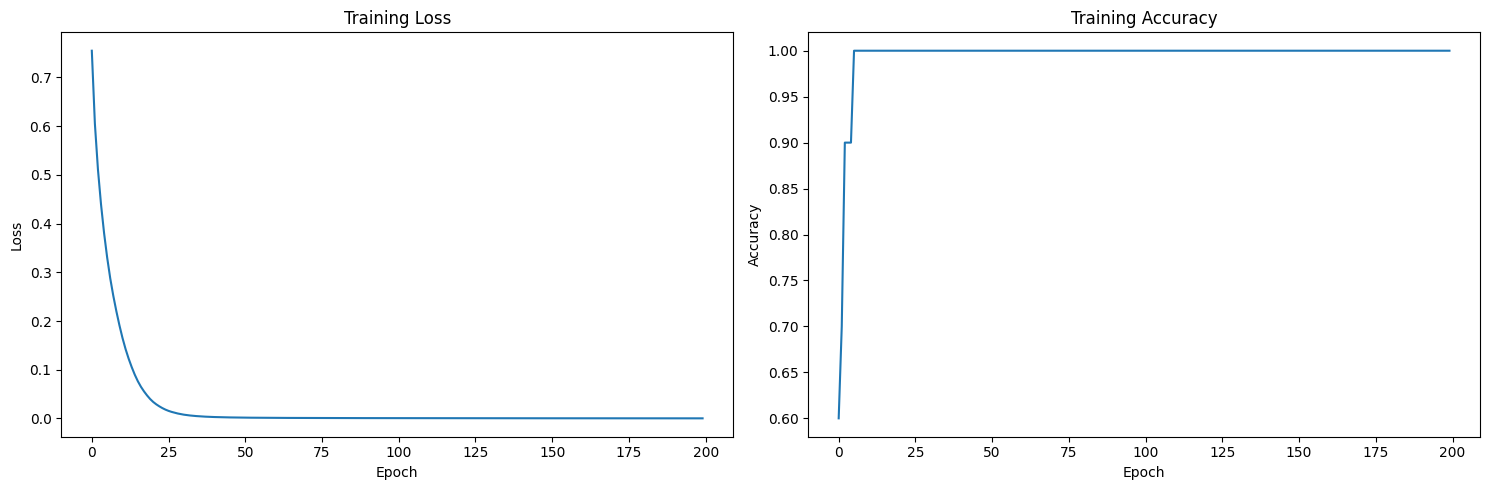


Model Evaluation:
Accuracy: 1.0000

Predictions vs True Labels:
Node 0: Predicted=0, True=0
Node 1: Predicted=1, True=1
Node 2: Predicted=1, True=1
Node 3: Predicted=1, True=1
Node 4: Predicted=0, True=0
Node 5: Predicted=0, True=0
Node 6: Predicted=0, True=0
Node 7: Predicted=1, True=1
Node 8: Predicted=0, True=0
Node 9: Predicted=1, True=1


In [15]:
 # 构建图数据
g = build_graph()

# 创建节点标签 (二分类)
labels = torch.tensor([[0], [1], [1], [1], [0], [0], [0], [1], [0], [1]], 
                        dtype=torch.float)

# 创建PyG的Data对象
data = Data(x=g.x, edge_index=g.edge_index, edge_attr=g.edge_attr)

# 移动到GPU（如果可用）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
labels = labels.to(device)

# 创建模型
model = GNNModel(in_channels=g.x.shape[1], 
                hidden_channels=32, 
                out_channels=1).to(device)

# 训练模型
losses, accuracies = train_model(model, data, labels, epochs=200, lr=0.01)

# 绘制训练历史
plot_training_history(losses, accuracies)

# 评估模型
final_acc = evaluate_model(model, data, labels)